In [1]:
import numpy as np
from numpy import argmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import plotly.express as px
import sklearn
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from scipy import stats
import dataframe_image as dfi
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor

C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def fetch_and_cache_gdrive(gdrive_id, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        download_file_from_google_drive(gdrive_id, file_path)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Note: if you have issue with fetch_and_cache_gdrive please download the Dataset A folder from google drive and paste it into data folder

In [3]:
# fetch_and_cache_gdrive('16-4O_lJGioPC5G9il4vR_XrCgJ3J9_zK', 'us_air_quality_measures.csv', data_dir = '../data/Dataset A/')
# fetch_and_cache_gdrive('15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ', 'daily_global_weather_2020.csv', data_dir = '../data/Dataset A/')
# fetch_and_cache_gdrive('1Y2oC3I6LFos0d755rqWnygHBcO2sYHZS', 'annual_aqi_by_county_2020.csv', data_dir = '../data/Dataset A/AQI_data/annual_county_aqi/')
# fetch_and_cache_gdrive('1rvNBpuoEOng9K_t_MXGHT-3GBvpHEmHj', 'daily_42101_2020.csv', data_dir = '../data/Dataset A/AQI_data/daily_co/')
# fetch_and_cache_gdrive('1uNH90XRceOfb16ctuUsYXVIEDeR2yaeC', 'daily_aqi_by_county_2020.csv', data_dir = '../data/Dataset A/AQI_data/daily_county_aqi/')
# fetch_and_cache_gdrive('1UEnZ2Z0as7vDXWIeBMOrGuz93A7UVlkd', '../data/Dataset A/AQI_data/daily_no2/daily_42602_2020.csv', data_dir = '')
# fetch_and_cache_gdrive('1kOFgB0YDlITWmja_izNEs8tegWJPr7kF', '../data/Dataset A/AQI_data/daily_ozone/daily_44201_2020.csv', data_dir = '')
# fetch_and_cache_gdrive('1KHP2r9SnAY2uzoXqMRoXARw0h3EWzFjk', '../data/Dataset A/AQI_data/daily_so2/daily_42401_2020.csv', data_dir = '')
# fetch_and_cache_gdrive('1Q62JlGtc65L2eU9FfQZcP9UyMCdcem1T', '../data/Dataset A/AQI_data/daily_temp/daily_TEMP_2020.csv', data_dir = '')
# fetch_and_cache_gdrive('18MqsjkN0EYPuLb0iR0U9sZYmNVCdd94h', '../data/Dataset A/AQI_data/daily_temp/daily_WIND_2020.csv', data_dir = '')

# Import all Datasets and Select the Initial Features

First of all we read all the csv files.

In [4]:
co_df= pd.read_csv('../data/Dataset A/AQI_Data/daily_co/daily_42101_2020.csv')
no2_df= pd.read_csv('../data/Dataset A/AQI_Data/daily_no2/daily_42602_2020.csv')
ozone_df= pd.read_csv('../data/Dataset A/AQI_Data/daily_ozone/daily_44201_2020.csv')
so2_df= pd.read_csv('../data/Dataset A/AQI_Data/daily_so2/daily_42401_2020.csv')
temp_df= pd.read_csv('../data/Dataset A/AQI_Data/daily_temp/daily_TEMP_2020.csv')
wind_df= pd.read_csv('../data/Dataset A/AQI_Data/daily_temp/daily_WIND_2020.csv')

In [5]:
wind_speed_df = wind_df[wind_df['Parameter Name']=='Wind Speed - Resultant']

In [6]:
df_list = [co_df, no2_df, ozone_df, so2_df, temp_df, wind_speed_df]
names = ['Carbon_Monoxide', 'Nitrogen_Dioxide', 'Ozone', 'Sulfur_Dioxide', 'Temperature', 'Wind_Speed']

We limit the scope of the project to counties in the State of California. \
There can be multiple studies by county in a single day with different methods, we'll take the average of those studies.

In [7]:
def reduce_df(df):
    df = df[df['State Name']=='California'][['County Code','Date Local','Arithmetic Mean']].groupby(['Date Local','County Code']).agg('mean')
    df = df.sort_values(['County Code', 'Date Local']).reset_index()
    return df
df_reduced = [df.pipe(reduce_df) for df in df_list]

In [8]:
for i in range(len(names)):
    df_reduced[i].columns.values[2] = names[i]

Let's merge the dataframes of all contaminants with the wind and temperature df.
We decided to deal with missing values by eliminating the corresponding rows.

In [9]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date Local', 'County Code'],
                                            how='outer'), df_reduced).sort_values(['County Code', 'Date Local']).dropna().reset_index(drop=True)

Let's calculate the lags from 1 to 5 for each contaminant.

In [10]:
lag1 = df_merged.groupby('County Code')[names].shift(-1)
lag2 = df_merged.groupby('County Code')[names].shift(-2)
lag3 = df_merged.groupby('County Code')[names].shift(-3)
lag4 = df_merged.groupby('County Code')[names].shift(-4)
lag5 = df_merged.groupby('County Code')[names].shift(-5)
df_lags = df_merged.join([lag1.rename(columns=lambda x: x+"_lag(1)"), 
                     lag2.rename(columns=lambda x: x+"_lag(2)"), 
                     lag3.rename(columns=lambda x: x+"_lag(3)"),
                     lag4.rename(columns=lambda x: x+"_lag(4)"),
                     lag5.rename(columns=lambda x: x+"_lag(5)")]).dropna()

In [11]:
df_lags

,Date Local,County Code,Carbon_Monoxide,Nitrogen_Dioxide,Ozone,Sulfur_Dioxide,Temperature,Wind_Speed,Carbon_Monoxide_lag(1),Nitrogen_Dioxide_lag(1),...,Ozone_lag(4),Sulfur_Dioxide_lag(4),Temperature_lag(4),Wind_Speed_lag(4),Carbon_Monoxide_lag(5),Nitrogen_Dioxide_lag(5),Ozone_lag(5),Sulfur_Dioxide_lag(5),Temperature_lag(5),Wind_Speed_lag(5)
0,2020-01-01,19,0.563523,12.088696,0.014519,0.129166,48.035417,1.595833,0.520751,12.826087,...,0.017775,0.000000,46.796354,3.847396,0.426537,11.968106,0.010107,0.052084,45.584375,1.761458
1,2020-01-02,19,0.520751,12.826087,0.010873,0.052084,47.408333,2.250000,0.531785,15.493043,...,0.010107,0.052084,45.584375,1.761458,0.389805,12.166930,0.012618,0.012500,41.086979,1.953646
2,2020-01-03,19,0.531785,15.493043,0.013696,0.127083,50.284375,1.782291,0.342258,9.514743,...,0.012618,0.012500,41.086979,1.953646,0.306441,10.379478,0.008431,0.000000,44.106250,2.293229
3,2020-01-04,19,0.342258,9.514743,0.019961,0.043750,52.025000,2.831771,0.233755,5.443123,...,0.008431,0.000000,44.106250,2.293229,0.301850,8.959130,0.017970,0.000000,46.016146,2.958854
4,2020-01-05,19,0.233755,5.443123,0.017775,0.000000,46.796354,3.847396,0.426537,11.968106,...,0.017970,0.000000,46.016146,2.958854,0.420430,13.658696,0.013059,0.043750,45.844791,1.603125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2020-12-22,85,0.597726,16.996997,0.017779,0.195000,50.875000,5.870833,0.672328,22.795356,...,0.019015,0.038095,53.375000,4.229167,0.513865,11.807807,0.021691,0.269048,50.750000,3.835000
3040,2020-12-23,85,0.672328,22.795356,0.013588,0.173810,49.416667,2.375000,0.930222,22.638537,...,0.021691,0.269048,50.750000,3.835000,0.454125,14.648222,0.016103,0.063095,50.470588,5.217647
3041,2020-12-24,85,0.930222,22.638537,0.009632,0.260714,47.409091,2.181818,0.418369,6.702174,...,0.016103,0.063095,50.470588,5.217647,0.643625,18.970887,0.013103,0.213095,44.400000,2.920000
3042,2020-12-25,85,0.418369,6.702174,0.030500,0.091667,55.208333,7.683333,0.444041,11.855731,...,0.013103,0.213095,44.400000,2.920000,0.655126,20.201373,0.014544,0.128421,47.000000,3.545833


Let's see if there are some missing values.

In [12]:
df_lags.isnull().sum()

Date Local                 0
County Code                0
Carbon_Monoxide            0
Nitrogen_Dioxide           0
Ozone                      0
Sulfur_Dioxide             0
Temperature                0
Wind_Speed                 0
Carbon_Monoxide_lag(1)     0
Nitrogen_Dioxide_lag(1)    0
Ozone_lag(1)               0
Sulfur_Dioxide_lag(1)      0
Temperature_lag(1)         0
Wind_Speed_lag(1)          0
Carbon_Monoxide_lag(2)     0
Nitrogen_Dioxide_lag(2)    0
Ozone_lag(2)               0
Sulfur_Dioxide_lag(2)      0
Temperature_lag(2)         0
Wind_Speed_lag(2)          0
Carbon_Monoxide_lag(3)     0
Nitrogen_Dioxide_lag(3)    0
Ozone_lag(3)               0
Sulfur_Dioxide_lag(3)      0
Temperature_lag(3)         0
Wind_Speed_lag(3)          0
Carbon_Monoxide_lag(4)     0
Nitrogen_Dioxide_lag(4)    0
Ozone_lag(4)               0
Sulfur_Dioxide_lag(4)      0
Temperature_lag(4)         0
Wind_Speed_lag(4)          0
Carbon_Monoxide_lag(5)     0
Nitrogen_Dioxide_lag(5)    0
Ozone_lag(5)  

We can also access to some information.

In [13]:
df_lags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 3043
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date Local               3004 non-null   object 
 1   County Code              3004 non-null   int64  
 2   Carbon_Monoxide          3004 non-null   float64
 3   Nitrogen_Dioxide         3004 non-null   float64
 4   Ozone                    3004 non-null   float64
 5   Sulfur_Dioxide           3004 non-null   float64
 6   Temperature              3004 non-null   float64
 7   Wind_Speed               3004 non-null   float64
 8   Carbon_Monoxide_lag(1)   3004 non-null   float64
 9   Nitrogen_Dioxide_lag(1)  3004 non-null   float64
 10  Ozone_lag(1)             3004 non-null   float64
 11  Sulfur_Dioxide_lag(1)    3004 non-null   float64
 12  Temperature_lag(1)       3004 non-null   float64
 13  Wind_Speed_lag(1)        3004 non-null   float64
 14  Carbon_Monoxide_lag(2)  

In [14]:
df_lags.describe()

,County Code,Carbon_Monoxide,Nitrogen_Dioxide,Ozone,Sulfur_Dioxide,Temperature,Wind_Speed,Carbon_Monoxide_lag(1),Nitrogen_Dioxide_lag(1),Ozone_lag(1),...,Ozone_lag(4),Sulfur_Dioxide_lag(4),Temperature_lag(4),Wind_Speed_lag(4),Carbon_Monoxide_lag(5),Nitrogen_Dioxide_lag(5),Ozone_lag(5),Sulfur_Dioxide_lag(5),Temperature_lag(5),Wind_Speed_lag(5)
count,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,...,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000
mean,60.908788,0.335614,9.841568,0.032165,0.327011,65.369393,3.706230,0.335574,9.841367,0.032167,...,0.032175,0.324757,65.275814,3.718587,0.334668,9.822603,0.032175,0.324622,65.256412,3.725158
std,22.295409,0.201622,6.848059,0.010495,0.310646,12.356482,1.553274,0.201538,6.848724,0.010492,...,0.010483,0.307620,12.376953,1.558980,0.200543,6.827354,0.010485,0.307041,12.369663,1.567461
min,19.000000,-0.066486,0.166864,0.001544,-0.139130,40.292361,0.350000,-0.066486,0.166864,0.001544,...,0.001544,-0.139130,39.780556,0.350000,-0.066486,0.166864,0.001544,-0.139130,39.780556,0.350000
25%,37.000000,0.193429,4.338611,0.025315,0.097619,55.383490,2.687951,0.193437,4.338611,0.025315,...,0.025309,0.097619,55.270644,2.704167,0.193704,4.352011,0.025308,0.097917,55.249380,2.706637
50%,67.000000,0.284707,8.195960,0.030843,0.225162,63.701562,3.340997,0.284707,8.195960,0.030843,...,0.030847,0.225000,63.664675,3.347954,0.284195,8.204189,0.030853,0.225162,63.653419,3.350231
75%,73.000000,0.448959,14.475440,0.038359,0.491250,73.825457,4.399339,0.448612,14.471352,0.038359,...,0.038359,0.482552,73.767495,4.408780,0.447002,14.438273,0.038359,0.481510,73.759014,4.415625
max,85.000000,1.700497,34.072332,0.074593,2.145834,103.694444,12.570833,1.700497,34.072332,0.074593,...,0.074593,2.145834,103.694444,12.570833,1.700497,34.072332,0.074593,2.145834,103.694444,12.570833


In [15]:
df_lags.shape

(3004, 38)

# Feature Engineering and EDA

### Distribution of Carbon Monoxide

As we focus on the Carbon Monoxide, we can explore this feature and plot some graphs.

Text(0.5, 0, 'Carbon Monoxide (parts per million)')

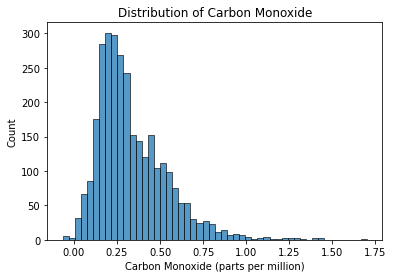

In [16]:
sns.histplot(df_lags['Carbon_Monoxide'])
plt.title('Distribution of Carbon Monoxide')
plt.xlabel('Carbon Monoxide (parts per million)')

C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Carbon_Monoxide'>

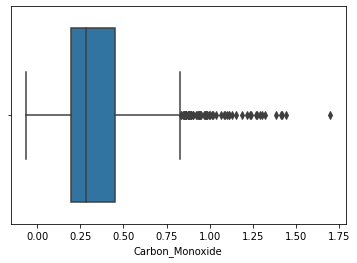

In [17]:
sns.boxplot(df_lags['Carbon_Monoxide'])

In [18]:
df_lags['Carbon_Monoxide'].describe()

count    3004.000000
mean        0.335614
std         0.201622
min        -0.066486
25%         0.193429
50%         0.284707
75%         0.448959
max         1.700497
Name: Carbon_Monoxide, dtype: float64

There are many outliers, on the distribution. It can be interesting to see the County code of these outliers.

In [19]:
df_lags[df_lags['Carbon_Monoxide'] >= 0.8]['County Code'].value_counts()

85    40
19    18
67     7
73     7
25     6
37     5
65     1
Name: County Code, dtype: int64

In [20]:
df_lags['County Code'].unique()

array([19, 25, 37, 65, 67, 71, 73, 83, 85], dtype=int64)

County code 85 is Santa Clara and code 19 is Fresno. That means there are the county with the most Carbon Monoxide concentration.

### Evolution of the Carbon Monoxide

Text(0, 0.5, 'Carbon Monoxide (parts in million)')

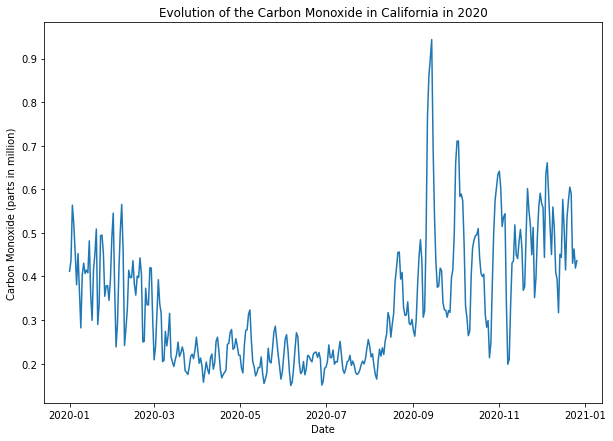

In [21]:
df1 = df_lags.copy()

df1['Date Local'] = pd.to_datetime(df1['Date Local'])
df1 = df1.set_index('Date Local')
df1 = df1.groupby(df1.index).mean()[['Carbon_Monoxide']]
plt.figure(figsize = (10,7))
plt.title('Evolution of the Carbon Monoxide in California in 2020')
plt.plot(df1)
plt.xlabel('Date')
plt.ylabel('Carbon Monoxide (parts in million)')

We can observe that the concentration of Carbon Monoxide was decreasing before July 2020. Then, there is a positive trend and some really high value of concentration (more than 0.9 in Sepember 2020). 

We must be careful with these peaks since some of them might be outliers (that will be discussed after).

## Temperature and Precipitation in California

Text(0, 0.5, 'Temperature (F)')

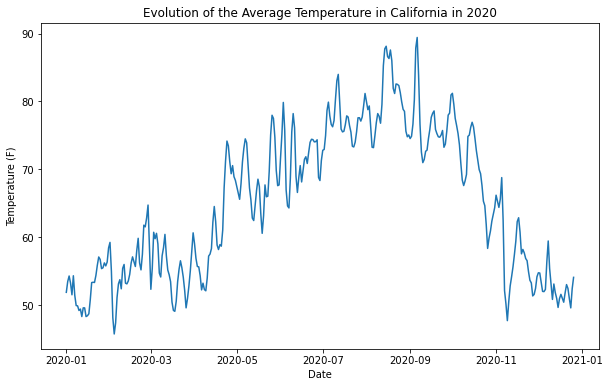

In [22]:
df2 = df_lags.copy()

df2['Date Local'] = pd.to_datetime(df2['Date Local'])
df2 = df2.set_index('Date Local')
df2 = df2.groupby(df2.index).mean()[['Temperature']]
plt.figure(figsize = (10,6))
plt.title('Evolution of the Average Temperature in California in 2020')
plt.plot(df2)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

Text(0, 0.5, 'Wind speed (knots)')

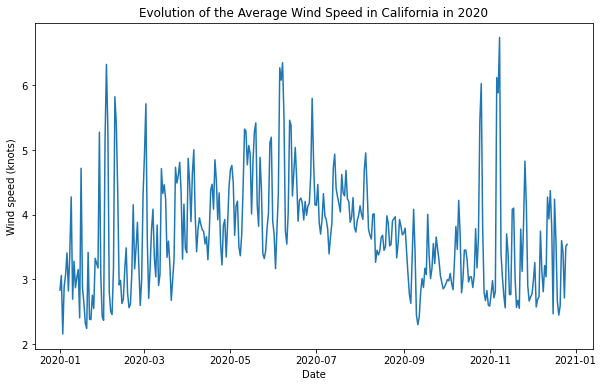

In [23]:
df3 = df_lags.copy()

df3['Date Local'] = pd.to_datetime(df3['Date Local'])
df3 = df3.set_index('Date Local')
df3 = df3.groupby(df3.index).mean()[['Wind_Speed']]
plt.figure(figsize = (10,6))
plt.title('Evolution of the Average Wind Speed in California in 2020')
plt.plot(df3)
plt.xlabel('Date')
plt.ylabel('Wind speed (knots)')

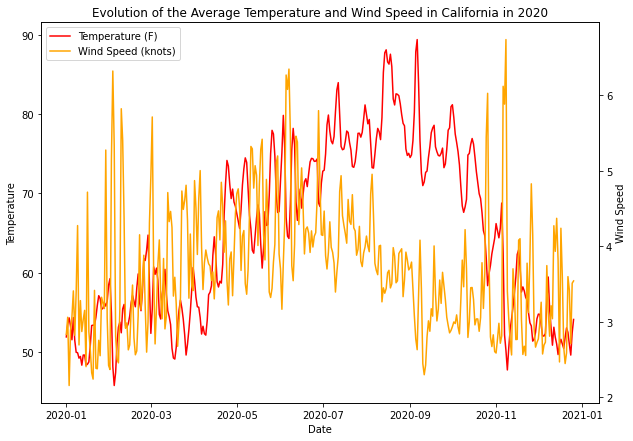

In [24]:
plt.figure(figsize=(10,7))
temp = df2
prec = df3

ax1 = plt.subplot()
l1, = ax1.plot(temp, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(prec, color='orange')


ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Wind Speed')


plt.title('Evolution of the Average Temperature and Wind Speed in California in 2020')

plt.legend([l1, l2], ["Temperature (F)", "Wind Speed (knots)"])

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

## Correlation 

### Pearson

<AxesSubplot:>

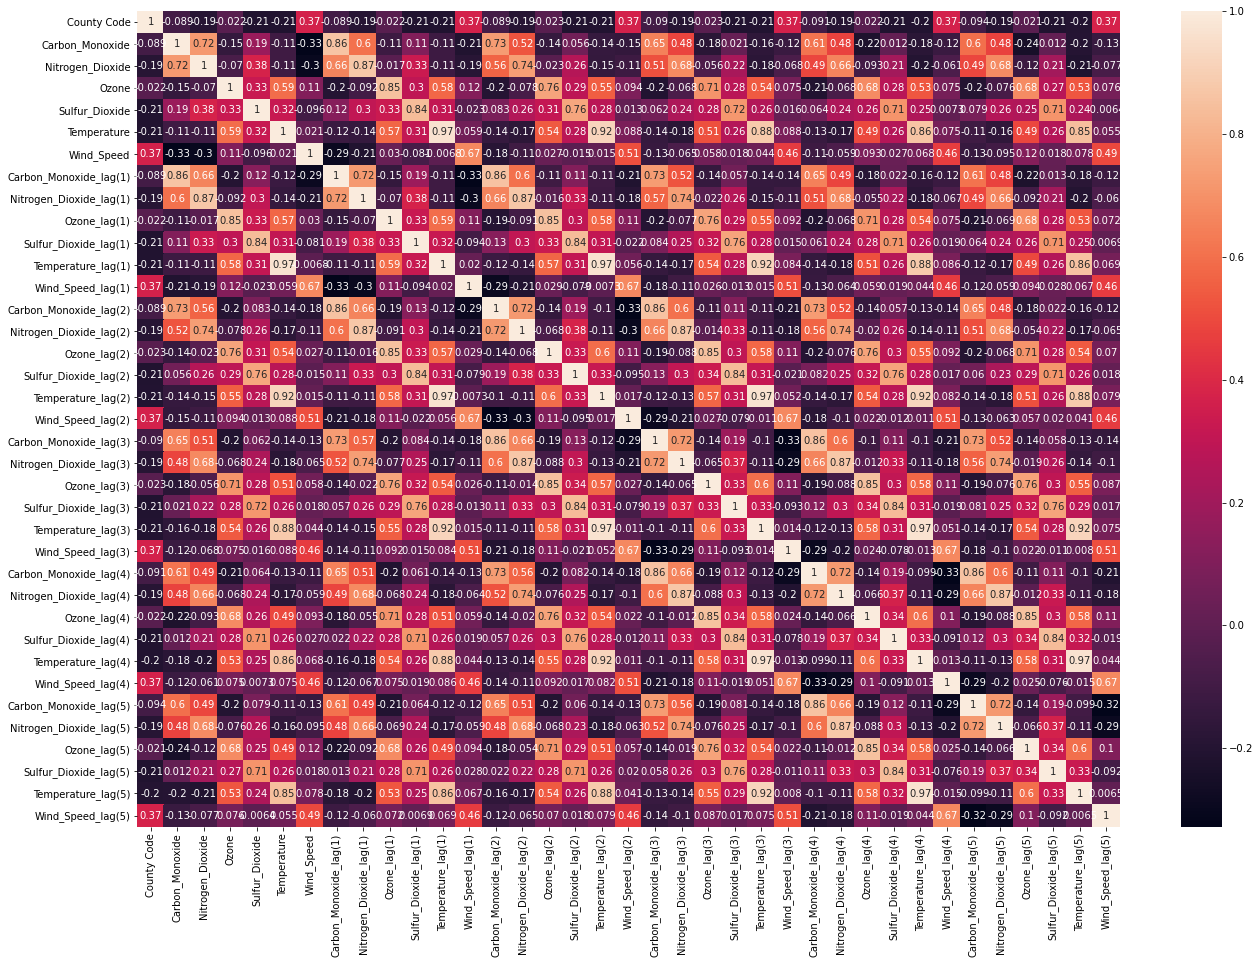

In [25]:
plt.figure(figsize = (22,15))
sns.heatmap(df_lags.corr(), annot = True)

Since we have too many features, it is hard to use this heatmap of correlation. Instead, we will use VIF.

### VIF

We will use VIF to remove multicollinearity between lag features. The threshold for keeping a feature is 5.

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def VIF(df, columns):
    
    values = sm.add_constant(df[columns]).values  # the dataframe passed to VIF must include the intercept term. We add it the same way we did before.
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    
    return pd.Series(vif[1:], index=columns)

In [27]:
X = df_lags.iloc[:, 6:]

In [28]:
max(VIF(df_lags, X.columns))

C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


49.74163459728991

In [29]:
a = VIF(df_lags, X.columns)
while max(a) > 5:
    X.drop(a.idxmax(), axis = 1, inplace = True)
    a = VIF(df_lags, X.columns)

a

C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\Aldo Alfaro\anaconda3\lib\site-packages\statsmodels

Temperature                4.763418
Wind_Speed                 2.199123
Carbon_Monoxide_lag(1)     2.624363
Ozone_lag(1)               3.131198
Sulfur_Dioxide_lag(1)      4.423227
Wind_Speed_lag(1)          2.786842
Sulfur_Dioxide_lag(2)      4.550921
Wind_Speed_lag(2)          2.651475
Nitrogen_Dioxide_lag(3)    3.665423
Ozone_lag(3)               3.509850
Wind_Speed_lag(3)          2.951855
Sulfur_Dioxide_lag(4)      4.566426
Wind_Speed_lag(4)          2.675050
Carbon_Monoxide_lag(5)     3.340546
Nitrogen_Dioxide_lag(5)    4.400735
Ozone_lag(5)               3.186281
Sulfur_Dioxide_lag(5)      4.522813
Temperature_lag(5)         4.962913
Wind_Speed_lag(5)          2.487653
dtype: float64

In [30]:
df = df_lags[df_lags.iloc[:,:8].columns.union(a.index, sort = False)]
df.head()

,Date Local,County Code,Carbon_Monoxide,Nitrogen_Dioxide,Ozone,Sulfur_Dioxide,Temperature,Wind_Speed,Carbon_Monoxide_lag(1),Ozone_lag(1),...,Ozone_lag(3),Wind_Speed_lag(3),Sulfur_Dioxide_lag(4),Wind_Speed_lag(4),Carbon_Monoxide_lag(5),Nitrogen_Dioxide_lag(5),Ozone_lag(5),Sulfur_Dioxide_lag(5),Temperature_lag(5),Wind_Speed_lag(5)
0,2020-01-01,19,0.563523,12.088696,0.014519,0.129166,48.035417,1.595833,0.520751,0.010873,...,0.019961,2.831771,0.000000,3.847396,0.426537,11.968106,0.010107,0.052084,45.584375,1.761458
1,2020-01-02,19,0.520751,12.826087,0.010873,0.052084,47.408333,2.250000,0.531785,0.013696,...,0.017775,3.847396,0.052084,1.761458,0.389805,12.166930,0.012618,0.012500,41.086979,1.953646
2,2020-01-03,19,0.531785,15.493043,0.013696,0.127083,50.284375,1.782291,0.342258,0.019961,...,0.010107,1.761458,0.012500,1.953646,0.306441,10.379478,0.008431,0.000000,44.106250,2.293229
3,2020-01-04,19,0.342258,9.514743,0.019961,0.043750,52.025000,2.831771,0.233755,0.017775,...,0.012618,1.953646,0.000000,2.293229,0.301850,8.959130,0.017970,0.000000,46.016146,2.958854
4,2020-01-05,19,0.233755,5.443123,0.017775,0.000000,46.796354,3.847396,0.426537,0.010107,...,0.008431,2.293229,0.000000,2.958854,0.420430,13.658696,0.013059,0.043750,45.844791,1.603125


### Normalize

Normalize data by substracting the mean and dividing by standard deviation.

In [31]:
df.iloc[:,2:].columns

Index(['Carbon_Monoxide', 'Nitrogen_Dioxide', 'Ozone', 'Sulfur_Dioxide',
       'Temperature', 'Wind_Speed', 'Carbon_Monoxide_lag(1)', 'Ozone_lag(1)',
       'Sulfur_Dioxide_lag(1)', 'Wind_Speed_lag(1)', 'Sulfur_Dioxide_lag(2)',
       'Wind_Speed_lag(2)', 'Nitrogen_Dioxide_lag(3)', 'Ozone_lag(3)',
       'Wind_Speed_lag(3)', 'Sulfur_Dioxide_lag(4)', 'Wind_Speed_lag(4)',
       'Carbon_Monoxide_lag(5)', 'Nitrogen_Dioxide_lag(5)', 'Ozone_lag(5)',
       'Sulfur_Dioxide_lag(5)', 'Temperature_lag(5)', 'Wind_Speed_lag(5)'],
      dtype='object')

In [32]:
df_norm = pd.DataFrame()
for col in df.iloc[:,2:].columns:
    df_norm[col] = (df[col] - df[col].mean()) / df[col].std()
df_norm

,Carbon_Monoxide,Nitrogen_Dioxide,Ozone,Sulfur_Dioxide,Temperature,Wind_Speed,Carbon_Monoxide_lag(1),Ozone_lag(1),Sulfur_Dioxide_lag(1),Wind_Speed_lag(1),...,Ozone_lag(3),Wind_Speed_lag(3),Sulfur_Dioxide_lag(4),Wind_Speed_lag(4),Carbon_Monoxide_lag(5),Nitrogen_Dioxide_lag(5),Ozone_lag(5),Sulfur_Dioxide_lag(5),Temperature_lag(5),Wind_Speed_lag(5)
0,1.130379,0.328141,-1.681336,-0.636881,-1.402825,-1.358677,0.918815,-2.029598,-0.885548,-0.937722,...,-1.166860,-0.567880,-1.055707,0.082624,0.458099,0.314251,-2.104800,-0.887629,-1.590345,-1.252790
1,0.918236,0.435820,-2.028806,-0.885018,-1.453574,-0.937523,0.973566,-1.760529,-0.643389,-1.238887,...,-1.375590,0.084104,-0.886396,-1.255391,0.274937,0.343373,-1.865320,-1.016548,-1.953928,-1.130180
2,0.972965,0.825267,-1.759819,-0.643586,-1.220818,-1.238635,0.033163,-1.163391,-0.912456,-0.563110,...,-2.107626,-1.254972,-1.015072,-1.132113,-0.140752,0.081565,-2.264607,-1.057259,-1.709841,-0.913534
3,0.032954,-0.047725,-1.162862,-0.911844,-1.079951,-0.562978,-0.505212,-1.371778,-1.053716,0.090867,...,-1.867915,-1.131596,-1.055707,-0.914289,-0.163649,-0.126472,-1.354790,-1.057259,-1.555440,-0.488882
4,-0.505197,-0.642291,-1.371186,-1.052680,-1.503101,0.090882,0.451341,-2.102608,-0.885548,-1.252301,...,-2.267586,-0.913599,-1.055707,-0.487327,0.427647,0.561871,-1.823227,-0.914770,-1.569293,-1.353803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,1.300017,1.044884,-1.370733,-0.424956,-1.173019,1.393574,1.670919,-1.770783,-0.492520,-0.857232,...,-0.160705,2.546601,-0.931869,0.327509,0.893556,0.290772,-0.999894,-0.181000,-1.172741,0.070076
3040,1.670027,1.891600,-1.770070,-0.493171,-1.291041,-0.857048,2.950542,-2.147842,-0.211921,-0.981625,...,-1.257207,0.329184,-0.181096,0.074673,0.595664,0.706807,-1.532918,-0.851766,-1.195330,0.952170
3041,2.949117,1.868700,-2.147015,-0.213415,-1.453513,-0.981419,0.410813,-0.158893,-0.757743,2.560887,...,-1.001657,0.076147,-0.850600,0.961565,1.540600,1.339946,-1.819030,-0.363231,-1.686094,-0.513670
3042,0.410446,-0.458436,-0.158668,-0.757597,-0.822326,2.560464,0.538191,-1.253589,-0.930714,0.336695,...,-1.535193,0.963743,-0.362984,-0.512250,1.597950,1.520175,-1.681565,-0.639006,-1.475902,-0.114405


### Outliers

Let's explore the boxplots of each feature (without their respective lags).

<AxesSubplot:>

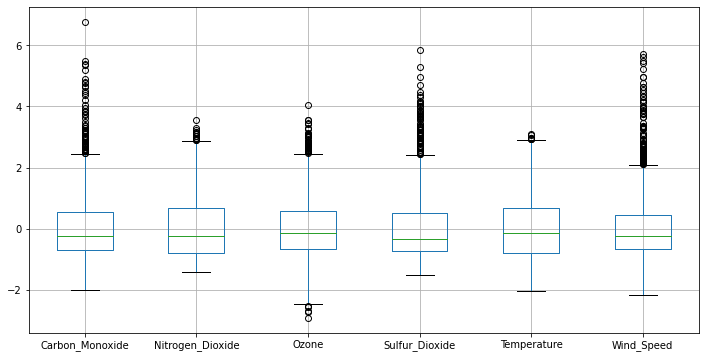

In [33]:
names = df_norm.iloc[:,0:6].columns
plt.figure(figsize=(12,6))
df_norm[names].boxplot()

We can see that there are many outliers. We will remove outliers that are 3 standard deviations away from the mean.

In [34]:
for name in names:
    df_out = df_norm[(np.abs(stats.zscore(df_lags[name])) <= 3)].reset_index(drop=True)

<AxesSubplot:>

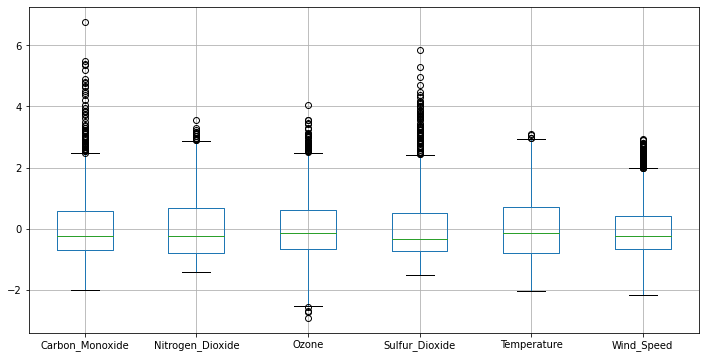

In [35]:
plt.figure(figsize=(12,6))
df_out[names].boxplot()

In [36]:
df_out.shape

(2964, 23)

Even if there are still some outliers, we removed some of them that would have had a negative impact on the model.

# Machine Learning Models

### OLS

In [37]:
df_out.head()

,Carbon_Monoxide,Nitrogen_Dioxide,Ozone,Sulfur_Dioxide,Temperature,Wind_Speed,Carbon_Monoxide_lag(1),Ozone_lag(1),Sulfur_Dioxide_lag(1),Wind_Speed_lag(1),...,Ozone_lag(3),Wind_Speed_lag(3),Sulfur_Dioxide_lag(4),Wind_Speed_lag(4),Carbon_Monoxide_lag(5),Nitrogen_Dioxide_lag(5),Ozone_lag(5),Sulfur_Dioxide_lag(5),Temperature_lag(5),Wind_Speed_lag(5)
0,1.130379,0.328141,-1.681336,-0.636881,-1.402825,-1.358677,0.918815,-2.029598,-0.885548,-0.937722,...,-1.166860,-0.567880,-1.055707,0.082624,0.458099,0.314251,-2.104800,-0.887629,-1.590345,-1.252790
1,0.918236,0.435820,-2.028806,-0.885018,-1.453574,-0.937523,0.973566,-1.760529,-0.643389,-1.238887,...,-1.375590,0.084104,-0.886396,-1.255391,0.274937,0.343373,-1.865320,-1.016548,-1.953928,-1.130180
2,0.972965,0.825267,-1.759819,-0.643586,-1.220818,-1.238635,0.033163,-1.163391,-0.912456,-0.563110,...,-2.107626,-1.254972,-1.015072,-1.132113,-0.140752,0.081565,-2.264607,-1.057259,-1.709841,-0.913534
3,0.032954,-0.047725,-1.162862,-0.911844,-1.079951,-0.562978,-0.505212,-1.371778,-1.053716,0.090867,...,-1.867915,-1.131596,-1.055707,-0.914289,-0.163649,-0.126472,-1.354790,-1.057259,-1.555440,-0.488882
4,-0.505197,-0.642291,-1.371186,-1.052680,-1.503101,0.090882,0.451341,-2.102608,-0.885548,-1.252301,...,-2.267586,-0.913599,-1.055707,-0.487327,0.427647,0.561871,-1.823227,-0.914770,-1.569293,-1.353803


In [38]:
X = df_out.iloc[:,4:]
y = df_out.iloc[:,:4]
Y = ['Carbon_Monoxide', 'Nitrogen_Dioxide', 'Ozone', 'Sulfur_Dioxide']

In [39]:
r2 = {'OLS':{'Train':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}, 'Test':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}},
     'Lasso':{'Train':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}, 'Test':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}},
     'Ridge':{'Train':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}, 'Test':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}},
     'RandomForest':{'Train':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}, 'Test':{'Carbon_Monoxide' : 0, 'Nitrogen_Dioxide' : 0, 'Ozone' : 0, 'Sulfur_Dioxide' : 0}}}

In [40]:
for Yi in Y:
    y = df_out.loc[:, Yi]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2['OLS']['Train'][Yi] = r2_score(y_train, y_train_pred)
    r2['OLS']['Test'][Yi] = r2_score(y_test, y_test_pred)

### Lasso

In [41]:
for Yi in Y:
    y = df_out[Yi]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    model = LassoCV(alphas=np.arange(0.0001, 0.1, 0.0001), cv=cv, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('alpha: %f' % model.alpha_)
    r2['Lasso']['Train'][Yi] = r2_score(y_train, y_train_pred)
    r2['Lasso']['Test'][Yi] = r2_score(y_test, y_test_pred)

alpha: 0.002200
alpha: 0.002400
alpha: 0.002100
alpha: 0.003600


### Ridge

In [42]:
for Yi in Y:
    y = df_out[Yi]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    model = RidgeCV(alphas=np.logspace(0, 5, 100), cv=cv)
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('alpha: %f' % model.alpha_)
    r2['Ridge']['Train'][Yi] = r2_score(y_train, y_train_pred)
    r2['Ridge']['Test'][Yi] = r2_score(y_test, y_test_pred)

alpha: 11.497570
alpha: 14.508288
alpha: 10.235310
alpha: 23.101297


### Random Forest Regressor

In [43]:
for Yi in Y:
    y = df_out[Yi]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2['RandomForest']['Train'][Yi] = r2_score(y_train, y_train_pred)
    r2['RandomForest']['Test'][Yi] = r2_score(y_test, y_test_pred)

In [44]:
r2

{'OLS': {'Train': {'Carbon_Monoxide': 0.807596087572864,
   'Nitrogen_Dioxide': 0.761523098487121,
   'Ozone': 0.781907767687145,
   'Sulfur_Dioxide': 0.763501448557685},
  'Test': {'Carbon_Monoxide': 0.7700479171517854,
   'Nitrogen_Dioxide': 0.7391804901238002,
   'Ozone': 0.7740862716495132,
   'Sulfur_Dioxide': 0.7431901311518827}},
 'Lasso': {'Train': {'Carbon_Monoxide': 0.8073232111092743,
   'Nitrogen_Dioxide': 0.7612227274808789,
   'Ozone': 0.7816161821099092,
   'Sulfur_Dioxide': 0.7629672597532569},
  'Test': {'Carbon_Monoxide': 0.7718144886592597,
   'Nitrogen_Dioxide': 0.7417357629539534,
   'Ozone': 0.7734246040395761,
   'Sulfur_Dioxide': 0.7422715929102925}},
 'Ridge': {'Train': {'Carbon_Monoxide': 0.8075334713649023,
   'Nitrogen_Dioxide': 0.7613885025402609,
   'Ozone': 0.7818613521357688,
   'Sulfur_Dioxide': 0.7633436662039648},
  'Test': {'Carbon_Monoxide': 0.7693770266377764,
   'Nitrogen_Dioxide': 0.7397245805558508,
   'Ozone': 0.77383383849852,
   'Sulfur_Dioxi

Compare efficiency of the models

In [45]:
r2_df = pd.DataFrame.from_dict(r2)

In [46]:
r2_OLS = r2_df['OLS'].apply(pd.Series).reset_index().melt(id_vars='index')
r2_Lasso = r2_df['Lasso'].apply(pd.Series).reset_index().melt(id_vars='index')
r2_Ridge = r2_df['Ridge'].apply(pd.Series).reset_index().melt(id_vars='index')
r2_RandomForest = r2_df['RandomForest'].apply(pd.Series).reset_index().melt(id_vars='index')
r2_OLS.columns.values[1] = "contaminant"
r2_Lasso.columns.values[1] = "contaminant"
r2_Ridge.columns.values[1] = "contaminant"
r2_RandomForest.columns.values[1] = "contaminant"
r2_OLS.columns.values[2] = "OLS"
r2_Lasso.columns.values[2] = "Lasso"
r2_Ridge.columns.values[2] = "Ridge"
r2_RandomForest.columns.values[2] = "RandomForest"
r2_models = pd.merge(r2_OLS,r2_Lasso.iloc[:,2], left_index=True, right_index=True)
r2_models = pd.merge(r2_models,r2_Ridge.iloc[:,2], left_index=True, right_index=True)
r2_models = pd.merge(r2_models,r2_RandomForest.iloc[:,2], left_index=True, right_index=True)
r2_pivot = r2_models.melt(id_vars=['index','contaminant'], var_name="variable")

In [47]:
r2_pivot

,index,contaminant,variable,value
0,Train,Carbon_Monoxide,OLS,0.807596
1,Test,Carbon_Monoxide,OLS,0.770048
2,Train,Nitrogen_Dioxide,OLS,0.761523
3,Test,Nitrogen_Dioxide,OLS,0.739180
4,Train,Ozone,OLS,0.781908
5,Test,Ozone,OLS,0.774086
6,Train,Sulfur_Dioxide,OLS,0.763501
7,Test,Sulfur_Dioxide,OLS,0.743190
8,Train,Carbon_Monoxide,Lasso,0.807323
9,Test,Carbon_Monoxide,Lasso,0.771814


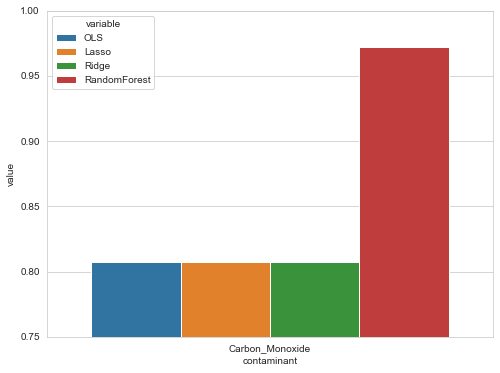

In [48]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
plt.ylim(0.75, 1)
# r2_pivot = r2_pivot.sort_values('value', ascending = False)
sns.barplot(x='contaminant', y='value', hue='variable', data=r2_pivot[(r2_pivot['index']=='Train')&(r2_pivot['contaminant']=='Carbon_Monoxide')])
plt.savefig('../figures/bar_r2_train.png')

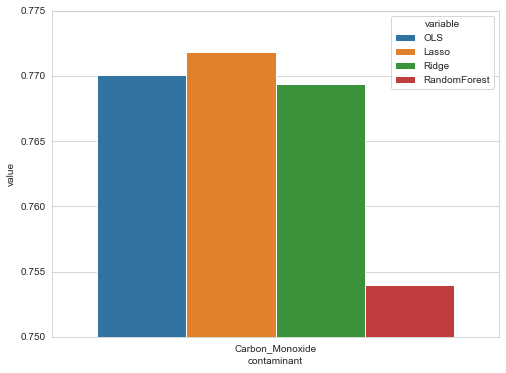

In [49]:
plt.figure(figsize=(8,6))
plt.ylim(0.75, 0.775)
sns.barplot(x='contaminant', y='value', hue='variable', data=r2_pivot[(r2_pivot['index']=='Test')&(r2_pivot['contaminant']=='Carbon_Monoxide')])
plt.savefig('../figures/bar_r2_test.png')

<ipython-input-54-dfb3c7f1088f>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.barplot(x='variable', y='value', hue='index', data=r2_pivot[r2_pivot['contaminant']=='Carbon_Monoxide'][(r2_pivot['contaminant']=='Carbon_Monoxide')])


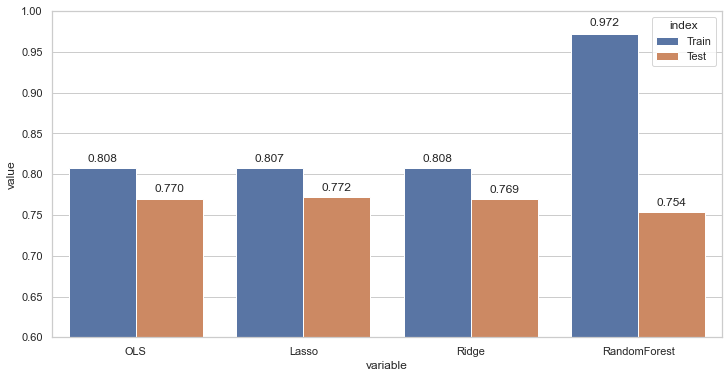

In [54]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
    
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("whitegrid")

ax = sns.barplot(x='variable', y='value', hue='index', data=r2_pivot[r2_pivot['contaminant']=='Carbon_Monoxide'][(r2_pivot['contaminant']=='Carbon_Monoxide')])
ax.set_ylim([0.6, 1])
show_values(ax)

plt.savefig('../figures/r2.png')

In [55]:
r2_models = r2_models.rename(columns={'index':'set'})
r2_train = r2_models[(r2_models['set']=='Train')&(r2_models['contaminant']=='Carbon_Monoxide')].reset_index(drop=True)
r2_test = r2_models[(r2_models['set']=='Test')&(r2_models['contaminant']=='Carbon_Monoxide')].reset_index(drop=True)
r2_test_train = r2_models[(r2_models['contaminant']=='Carbon_Monoxide')].reset_index(drop=True)
dfi.export(r2_train,'../figures/r2_train.png')
dfi.export(r2_test,'../figures/r2_test.png')
dfi.export(r2_test_train,'../figures/r2_df.png')